# Lab 3: Modelling order books.

Jeremy Marck, Nam Nguyen.

## 2. Implementation.

This section is dedicated to the implementation of the Algorithm 1 (simulation of the limit order book).

The following function implements the algorithm purposed and returns a pandas DataFrame, which gives, at each time: ask and bid prices, the spread, ask and bid volumes, mid and weighted mid prices and the case.

Other returns are lists of probabilities so as to realize sanity check. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def orderbooksimulation(N,K,mu,lamda,theta,init,T):
    t = 0
    x = np.zeros(N)
    l_c = []
    for i in range(N):
        x[i] = init[i]
    l_bid_price = []
    l_ask_price = []
    l_bid_volume = []
    l_ask_volume = []
    l_case = []
    mid_price = []
    spread = []
    weighted_mid_price = []
    l_time = []
    bmo = 0
    amo = 0
    blo = 0
    alo = 0
    total = 0
    bid_shape=[]
    ask_shape=[]
    while t < T:
        l_time.append(t)
        bid_price = np.argwhere(x <- 0.5)[-1][0]
        ask_price = np.argwhere(x > 0.5)[0][0]
        z=x[x!=0]
        now_price = np.argwhere(z <- 0.5)[-1][0]
        bid_shape.append(z[now_price-9:now_price+1])
        ask_shape.append(z[now_price+1:now_price+11])
        l_bid_price.append(bid_price)
        l_ask_price.append(ask_price)
        l_bid_volume.append(x[bid_price])
        l_ask_volume.append(x[ask_price])
        mid_price.append((bid_price + ask_price)/2)
        spread.append(ask_price - bid_price)
        weighted_mid_price.append((ask_price * x[ask_price] - bid_price * x[bid_price])/(x[ask_price] - x[bid_price]))
        if bid_price + K < N:   
            ask_window = np.arange(bid_price + 1,bid_price + K + 1)
        else: 
            ask_window = np.arange(bid_price + 1,N)
        if ask_price - K > 0:
            bid_window = np.arange(ask_price - K,ask_price)
        else: 
            bid_window = np.arange(0,ask_price-1)
        intensity_vector = [mu,mu,K * lamda,K * lamda,theta * sum(abs(x[bid_window])),theta * sum(abs(x[ask_window]))]
        probas = intensity_vector/sum(intensity_vector)
        delta = np.random.exponential(1./max(intensity_vector))
        case = np.random.choice(np.arange(0,6),p = intensity_vector/sum(intensity_vector))
        total += 1
        if case == 0:
            x[ask_price] -= 1
            bmo += 1
        elif case == 1:
            x[bid_price] += 1
            amo += 1
        elif case == 2:
            x[np.random.choice(bid_window)] -= 1
            blo += 1
        elif case == 3:
            x[np.random.choice(ask_window)] += 1
            alo += 1
        elif case == 4:
            x[np.random.choice(bid_window,p = x[bid_window]/sum(x[bid_window]))] += 1
        elif case == 5:
            x[np.random.choice(ask_window,p = x[ask_window]/sum(x[ask_window]))] -= 1
        l_case.append(case)
        t = t + delta
    d = {'Time': l_time, 'Ask price': l_ask_price,'Bid price': l_bid_price, 'Bid_volume': l_bid_volume,'Ask_volume':l_ask_volume,'Spread': spread,'Mid price':mid_price,'Weighted mid price':weighted_mid_price,'Case':l_case}
    df = pd.DataFrame(data = d)  
    l = [bmo/total,amo/total,blo/total,alo/total,total]
    
    return df, l,probas,bid_shape,ask_shape

## 3. Sanity check.

This section is dedicated to the verification of the implementation of our order book. 

In [3]:
# Runing the algorithm.
Y = np.zeros(1000)
Y[range(500)] =- 10
Y[range(500,999)] = 10
b = orderbooksimulation(1000,10,2.5,1,0.2,Y,10000)

### 3.1. Printing a small extract of the csv output.

In [4]:
data = b[0]
data.head()

Time  Ask price  Bid price  Bid_volume  Ask_volume  Spread  Mid price  \
0  0.000000        500        499       -10.0        10.0       1      499.5   
1  0.018183        500        499       -10.0        10.0       1      499.5   
2  0.134568        500        499       -10.0        10.0       1      499.5   
3  0.142438        500        499       -10.0        10.0       1      499.5   
4  0.248519        500        499        -9.0        10.0       1      499.5   

   Weighted mid price  Case  
0          499.500000     4  
1          499.500000     5  
2          499.500000     5  
3          499.500000     1  
4          499.526316     5

Orders are correctly processed.

## 3.2. Checking that the number of bid and ask market and limit orders in the simulation is correct.

Realized by using the ouput of the orderbooksimulation function.

We use the orderbooksimulation function that returns the list (l) of events performed in occurrences that we compare with the list of probabilities (probas). Everything seems to work.

In [5]:
for i in range(4):
    print('Realization:', round(b[1][i],3), 'versus probability:', round(b[2][i],3))

Realization: 0.063 versus probability: 0.065
Realization: 0.063 versus probability: 0.065
Realization: 0.248 versus probability: 0.262
Realization: 0.25 versus probability: 0.262


## 3.3. Checking the placement of limit order books in the simulation is correct (uniform distribution).

One should recall that limit orders correspond to cases 3 and 4.

We perform the algoritm 10 times with an horizon $T = 10 000$ to check that the placement of limit orders is stable.

In [6]:
l_placements = []
l_probas = []
for i in range(1,11):
    print('Simulation', i)
    Y = np.zeros(1000)
    Y[range(500)] =- 10
    Y[range(500,999)] = 10
    b = orderbooksimulation(1000,10,2.5,1,0.2,Y,10000)
    data = b[0]
    somme = 0
    for i in range(len(data)):
        if data['Case'][i] == 2 or data['Case'][i] == 3:
            somme += 1
    print('Placement of limit order:', round(somme/len(data),3))
    print('Associated intensities (probas)', round(b[2][2] + b[2][3],3))
    l_placements.append(somme/len(data))
    l_probas.append(b[2][2] + b[2][3])
    print('****************')
print('Final Check:')
print('*********')
print('Mean of placement of limit order books:', round(np.mean(l_placements),2))
print('Standard deviation of placement of limit order books', round(np.std(l_placements),2))
print('Mean of associated probas:', round(np.mean(l_probas),2))
print('Standard deviation of associated probas', round(np.std(l_probas),2))

Simulation 1
Placement of limit order: 0.498
Associated intensities (probas) 0.465
****************
Simulation 2
Placement of limit order: 0.498
Associated intensities (probas) 0.498
****************
Simulation 3
Placement of limit order: 0.498
Associated intensities (probas) 0.463
****************
Simulation 4
Placement of limit order: 0.499
Associated intensities (probas) 0.513
****************
Simulation 5
Placement of limit order: 0.498
Associated intensities (probas) 0.488
****************
Simulation 6
Placement of limit order: 0.498
Associated intensities (probas) 0.498
****************
Simulation 7
Placement of limit order: 0.498
Associated intensities (probas) 0.513
****************
Simulation 8
Placement of limit order: 0.499
Associated intensities (probas) 0.472
****************
Simulation 9
Placement of limit order: 0.498
Associated intensities (probas) 0.483
****************
Simulation 10
Placement of limit order: 0.498
Associated intensities (probas) 0.508
****************

Hence the distribution of placement of limit order books is uniformly distributed and very stable.

# 4. Main analysis.

## 4.1. Shape of the simulated LOB.

In [7]:
# Runing the algorithm
Y = np.zeros(1000)
Y[range(500)] =- 10
Y[range(500,999)] = 10
b, a, c, bid_shape, ask_shape = orderbooksimulation(1000,10,2.5,1,0.2,Y,10000)


In [8]:
bid_final = sum(bid_shape)/len(bid_shape)
ask_final = sum(ask_shape)/len(bid_shape)

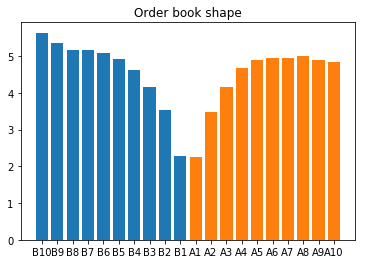

In [9]:
plt.bar(range(1,11),abs(bid_final))
plt.bar(range(11,21),abs(ask_final))
plt.title('Order book shape')
plt.xticks(np.arange(1,21),labels=['B10','B9','B8','B7','B6','B5','B4','B3','B2','B1','A1','A2','A3','A4','A5','A6','A7','A8','A9','A10'])
plt.show()

## 4.2. Plotting the spread distribution

In [10]:
# Runing the algorithm
Y = np.zeros(1000)
Y[range(500)] =- 10
Y[range(500,999)] = 10
b = orderbooksimulation(1000,10,2.5,1,0.2,Y,10000)
data = b[0]

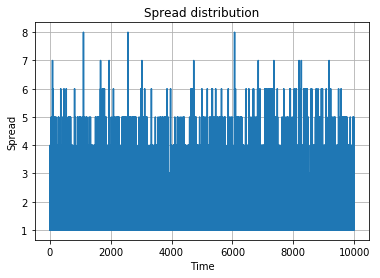

In [11]:
#Spread
plt.plot(data['Time'],data['Spread'])
plt.title('Spread distribution')
plt.xlabel('Time')
plt.ylabel('Spread')
plt.grid(True)
plt.show()

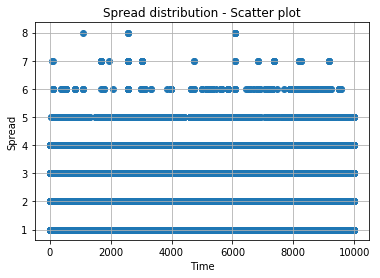

In [12]:
plt.scatter(data['Time'],data['Spread'])
plt.title('Spread distribution - Scatter plot')
plt.xlabel('Time')
plt.ylabel('Spread')
plt.grid(True)
plt.show()

## 4.3. Plotting the Mid-price distribution at a large scale.

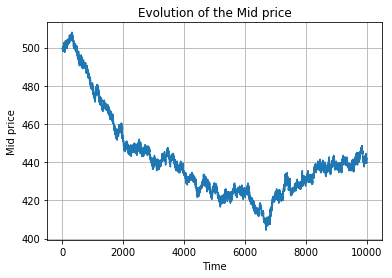

In [13]:
plt.plot(data['Time'], data['Mid price'])
plt.title('Evolution of the Mid price')
plt.xlabel('Time')
plt.ylabel('Mid price')
plt.grid(True)
plt.show()

## 4.4. Plotting the bid, ask and mid price at a small scale on the same graph.

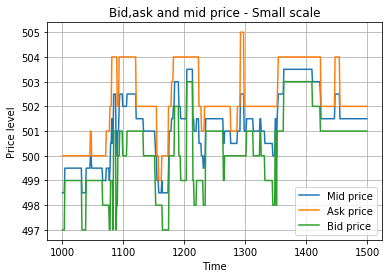

In [14]:
plt.plot(data['Mid price'][1000:1500], label = 'Mid price')
plt.plot(data['Ask price'][1000:1500], label = 'Ask price')
plt.plot(data['Bid price'][1000:1500], label = 'Bid price')
plt.title('Bid,ask and mid price - Small scale')
plt.xlabel('Time')
plt.ylabel('Price level')
plt.legend()
plt.grid(True)
plt.show()

Unsurprisingly, bid_price < mid_price < ask_price. 

## 4.5. Adding the weighted mid-price.

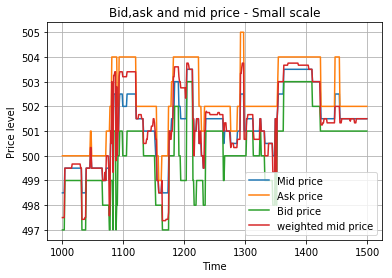

In [15]:
plt.plot(data['Mid price'][1000:1500], label = 'Mid price')
plt.plot(data['Ask price'][1000:1500], label = 'Ask price')
plt.plot(data['Bid price'][1000:1500], label = 'Bid price')
plt.plot(data['Weighted mid price'][1000:1500], label = 'weighted mid price')
plt.title('Bid,ask and mid price - Small scale')
plt.xlabel('Time')
plt.ylabel('Price level')
plt.legend()
plt.grid(True)
plt.show()

The weighted mid price weight the price according to whether it is determined by the bid side or the ask side. It is a weighted mid price whose main interest consists in reproducing important variations from the ask side or the bid side.

## 4.6. Plotting the distribution of mid-price increments.

In [16]:
# Building the mid-price increments.
mid_price = data['Mid price']
mid_price_diff = data['Mid price'].diff().dropna()
#mid_price_diff = mid_price_diff.dropna()
mid_price_diff_10 = data['Mid price'].diff(periods = 10).dropna()
#mid_price_diff_10.dropna()
mid_price_diff_30 = data['Mid price'].diff(periods = 30).dropna()
#mid_price_diff_30.dropna()
mid_price_diff_50 = data['Mid price'].diff(periods = 50).dropna()
#mid_price_diff_50.dropna()

In [17]:
# Identifying increments values
a = mid_price_diff.unique()
print('Values of mid-price increments:',a)
print('Number of values:', len(a))

Values of mid-price increments: [ 0.  -0.5  0.5 -1.   1.   1.5 -1.5  2.  -2.   2.5 -2.5 -3.   3. ]
Number of values: 13


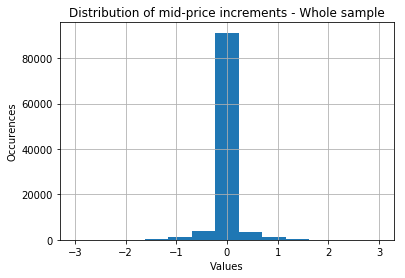

In [18]:
# Plotting the distribution for the whole sample.
plt.hist(mid_price_diff, bins = 13)
plt.title('Distribution of mid-price increments - Whole sample')
plt.xlabel('Values')
plt.ylabel('Occurences')
plt.grid(True)
plt.show()

The vast majority of mid-price increments are 0.

Let us plot the distribution for several sampling periods.

By selecting some data intervals.

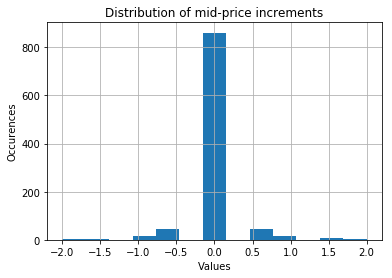

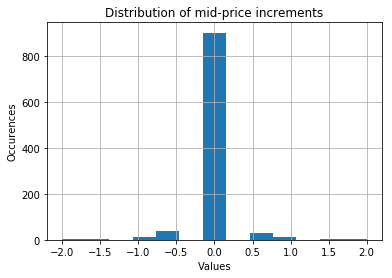

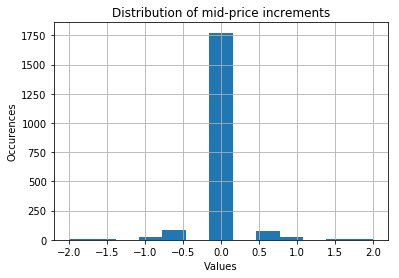

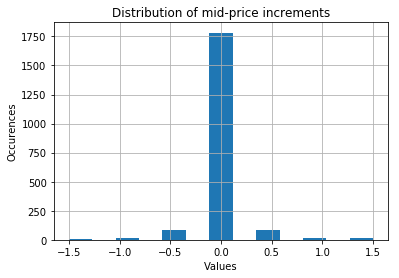

In [19]:
plt.hist(mid_price_diff[1000:2000], bins = 13)
plt.title('Distribution of mid-price increments')
plt.xlabel('Values')
plt.ylabel('Occurences')
plt.grid(True)
plt.show()

plt.hist(mid_price_diff[5000:6000], bins = 13)
plt.title('Distribution of mid-price increments')
plt.xlabel('Values')
plt.ylabel('Occurences')
plt.grid(True)
plt.show()

plt.hist(mid_price_diff[10000:12000], bins = 13)
plt.title('Distribution of mid-price increments')
plt.xlabel('Values')
plt.ylabel('Occurences')
plt.grid(True)
plt.show()

plt.hist(mid_price_diff[50000:52000], bins = 13)
plt.title('Distribution of mid-price increments')
plt.xlabel('Values')
plt.ylabel('Occurences')
plt.grid(True)
plt.show()

By selecting some different lags.

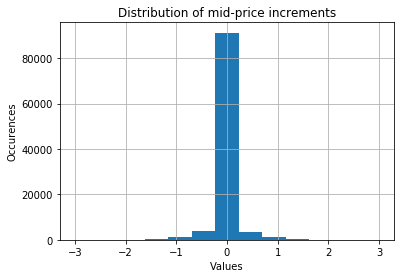

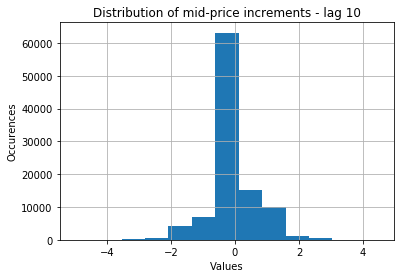

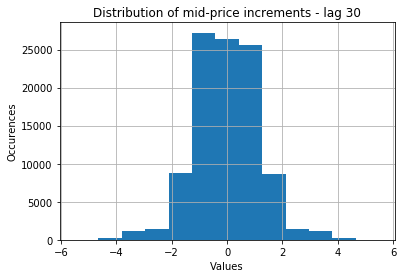

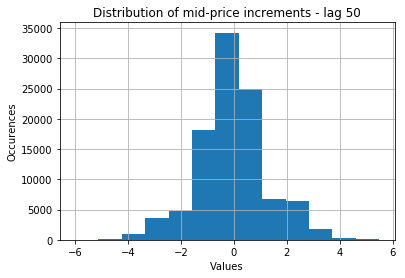

In [20]:
plt.hist(mid_price_diff, bins = 13)
plt.title('Distribution of mid-price increments')
plt.xlabel('Values')
plt.ylabel('Occurences')
plt.grid(True)
plt.show()

plt.hist(mid_price_diff_10, bins = 13)
plt.title('Distribution of mid-price increments - lag 10')
plt.xlabel('Values')
plt.ylabel('Occurences')
plt.grid(True)
plt.show()

plt.hist(mid_price_diff_30, bins = 13)
plt.title('Distribution of mid-price increments - lag 30')
plt.xlabel('Values')
plt.ylabel('Occurences')
plt.grid(True)
plt.show()

plt.hist(mid_price_diff_50, bins = 13)
plt.title('Distribution of mid-price increments - lag 50')
plt.xlabel('Values')
plt.ylabel('Occurences')
plt.grid(True)
plt.show()

Same conclusion: The vast majority of mid-price increments are 0.

## 4.7. Plotting the autocorrelation of the mid-price increments.

To perform such a task, we use the so-called stats.models library.

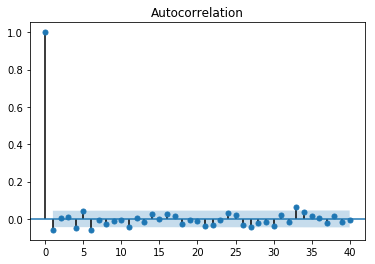

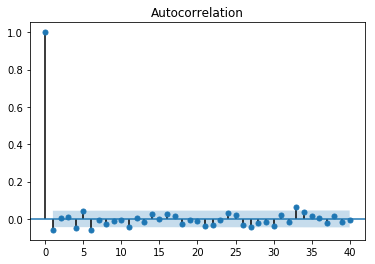

In [21]:
import statsmodels.graphics.tsaplots as tsa
tsa.plot_acf(mid_price_diff[1000:3000], lags = 40)

Using lag = 40 and diff = 10.

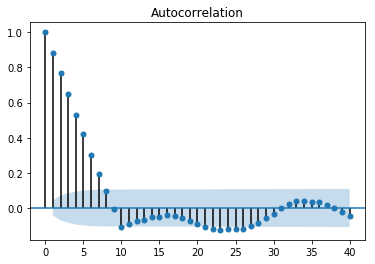

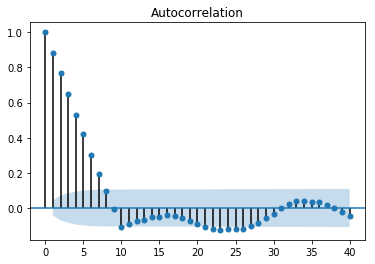

In [22]:
tsa.plot_acf(mid_price_diff_10[1000:3000], lags = 40)

Using lag = 40 and diff = 30.

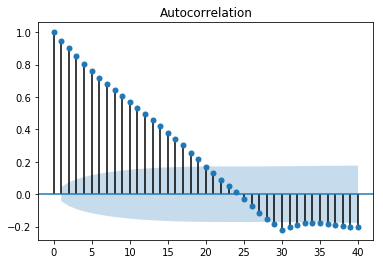

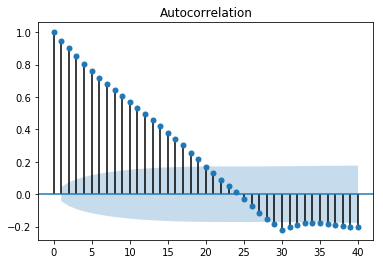

In [23]:
tsa.plot_acf(mid_price_diff_30[1000:3000], lags = 40)

Using lag = 50 and diff = 10.

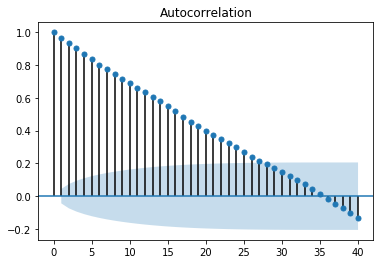

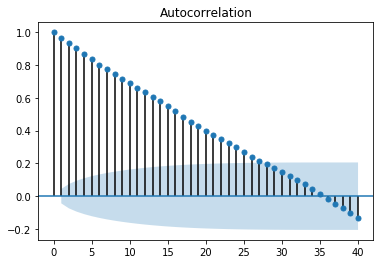

In [24]:
tsa.plot_acf(mid_price_diff_50[1000:3000], lags = 40)

The model seems to exhibit long-term memory.

## 4.8. Plotting the variance of mid-price increments as a function of the sampling period.

In [25]:
time = 0
price_var = []
while time < 100000:
    time += 10
    mid_price  = data['Mid price'][data['Time']< time]
    price_var.append(np.var(np.diff(mid_price)))

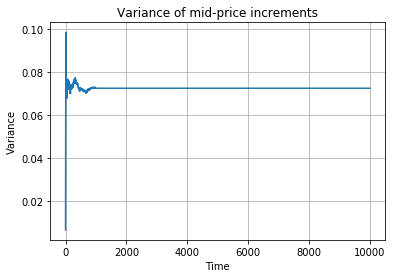

In [26]:
plt.plot(price_var)
plt.title('Variance of mid-price increments')
plt.ylabel('Variance')
plt.xlabel('Time')
plt.grid(True)
plt.show()

The variance quickly around 0,07.

# 5. Advanced analysis.

This part will be dedicated to studying the influence of changing a parameter.
The user can set the value of the desired parameter using the adequate function (mu, lambda, theta).

In [27]:
def influence_mu(mu):
    
    # Initial parameters values
    Y = np.zeros(1000)
    Y[range(500)] =- 10
    Y[range(500,999)] = 10
    b = orderbooksimulation(1000,10,2.5,1,0.2,Y,10000)
    data = b[0]

    # New parameters values
    Y = np.zeros(1000)
    Y[range(500)] =- 10
    Y[range(500,999)] = 10
    b = orderbooksimulation(1000,10,mu,1,0.2,Y,10000)
    newdata = b[0]
    
    # Spread part:
    ##############
    print('**** Spread part ****')
    #Spread
    print('** Inital parameter Values **')
    plt.plot(data['Time'],data['Spread'])
    plt.title('Spread distribution')
    plt.xlabel('Time')
    plt.ylabel('Spread')
    plt.grid(True)
    plt.show()

    #Spread
    print('** New parameter values **')
    plt.plot(newdata['Time'],newdata['Spread'])
    plt.title('Spread distribution')
    plt.xlabel('Time')
    plt.ylabel('Spread')
    plt.grid(True)
    plt.show()
    
    # Comparison
    print('Min spread - initial parameter values:',min(data['Spread']),'Min spread - new parameter values:', min(newdata['Spread']))
    print('Max spread - initial parameter values:',max(data['Spread']),'Max spread - new parameter values:',max(newdata['Spread']))
    print('Mean spread - initial parameter values:',np.mean(data['Spread']),'Mean spread - new parameter values:',np.mean(newdata['Spread']))
    print('75% quantile spread - initial parameter values:',np.quantile(data['Spread'],0.75),'Mean spread - new parameter values:',np.quantile(newdata['Spread'],0.75))
    
    # Mid price:
    ##############
    print('**** Mid-price part ****')
    # Mid price
    print('** Inital parameter Values **')
    plt.plot(data['Time'],data['Mid price'])
    plt.title('Mid price')
    plt.xlabel('Time')
    plt.ylabel('Mid price')
    plt.grid(True)
    plt.show()

    # Mid price
    print('** New parameter values **')
    plt.plot(newdata['Time'],newdata['Mid price'])
    plt.title('Mid price')
    plt.xlabel('Time')
    plt.ylabel('Mid price')
    plt.grid(True)
    plt.show()
    
    # Comparison
    print('Min mid-price - initial parameter values:',min(data['Mid price']),'Min mid-price - new parameter values:', min(newdata['Mid price']))
    print('Max mid-price - initial parameter values:',max(data['Mid price']),'Max mid-price - new parameter values:',max(newdata['Mid price']))
    print('Mean mid-price - initial parameter values:',np.mean(data['Mid price']),'Mean mid-price - new parameter values:',np.mean(newdata['Mid price']))
    print('75% quantile mid-price - initial parameter values:',np.quantile(data['Mid price'],0.75),'Mean mid-price - new parameter values:', np.quantile(newdata['Mid price'],0.75))
    
    # Weighted mid-price:
    ##############
    print('**** Weighted Mid-price part ****')
    #WMP
    print('** Inital parameter Values **')
    plt.plot(data['Mid price'][1000:1500], label = 'Mid price')
    plt.plot(data['Ask price'][1000:1500], label = 'Ask price')
    plt.plot(data['Bid price'][1000:1500], label = 'Bid price')
    plt.plot(data['Weighted mid price'][1000:1500], label = 'weighted mid price')
    plt.title('Bid,ask and mid price - Small scale')
    plt.xlabel('Time')
    plt.ylabel('Price level')
    plt.legend()
    plt.grid(True)
    plt.show()

    #WMP
    print('** New parameter values **')
    plt.plot(newdata['Mid price'][1000:1500], label = 'Mid price')
    plt.plot(newdata['Ask price'][1000:1500], label = 'Ask price')
    plt.plot(newdata['Bid price'][1000:1500], label = 'Bid price')
    plt.plot(newdata['Weighted mid price'][1000:1500], label = 'Weighted mid price')
    plt.title('Bid,ask and mid price - Small scale')
    plt.xlabel('Time')
    plt.ylabel('Price level')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Comparison
    print('Min weighted mid-price - initial parameter values:',min(data['Weighted mid price']),'Min weighted mid-price - new parameter values:', min(newdata['Weighted mid price']))
    print('Max weighted mid-price - initial parameter values:',max(data['Weighted mid price']),'Max weighted mid-price - new parameter values:',max(newdata['Weighted mid price']))
    print('Mean weighted mid-price - initial parameter values:',np.mean(data['Weighted mid price']),'Mean weighted mid-price - new parameter values:',np.mean(newdata['Weighted mid price']))
    print('75% quantile weighted mid-price - initial parameter values:',np.quantile(data['Weighted mid price'],0.75),'Mean weighted mid-price - new parameter values:', np.quantile(newdata['Weighted mid price'],0.75))
    
    
     # Mid-price increments:
    ##############
    print('**** Mid-price increments part ****')
    
    #Increments
    print('** Inital parameter Values **')
    mid_price = data['Mid price']
    mid_price_diff = data['Mid price'].diff()
    mid_price_diff = mid_price_diff.dropna()
    plt.hist(mid_price_diff, bins = 13)
    plt.title('Distribution of mid-price increments - Whole sample')
    plt.xlabel('Values')
    plt.ylabel('Occurences')
    plt.grid(True)
    plt.show()
    
    #Increments
    print('** New parameter values **')
    mid_price = newdata['Mid price']
    mid_price_diff_new = newdata['Mid price'].diff()
    mid_price_diff_new = mid_price_diff_new.dropna()
    plt.hist(mid_price_diff_new, bins = 13)
    plt.title('Distribution of mid-price increments - Whole sample')
    plt.xlabel('Values')
    plt.ylabel('Occurences')
    plt.grid(True)
    plt.show()
    
    # Autocorrelation part:
    ##############
    
    # Initial parameter values
    print('** Initial parameter values **')
    import statsmodels.graphics.tsaplots as tsa
    tsa.plot_acf(mid_price_diff[:1000])
    
    # New parameter values
    print('** New parameter values **')
    import statsmodels.graphics.tsaplots as tsa
    tsa.plot_acf(mid_price_diff_new[:1000])


**** Spread part ****
** Inital parameter Values **


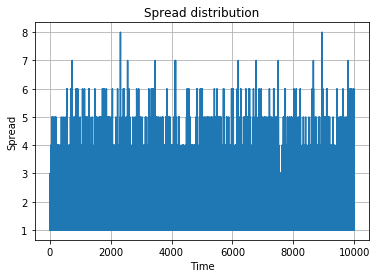

** New parameter values **


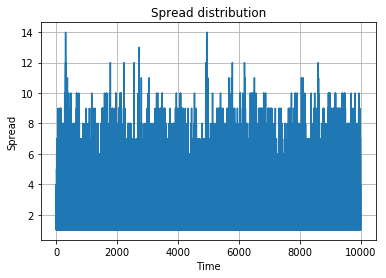

Min spread - initial parameter values: 1 Min spread - new parameter values: 1
Max spread - initial parameter values: 8 Max spread - new parameter values: 14
Mean spread - initial parameter values: 1.9471334817997281 Mean spread - new parameter values: 3.0714581607290805
75% quantile spread - initial parameter values: 3.0 Mean spread - new parameter values: 4.0
**** Mid-price part ****
** Inital parameter Values **


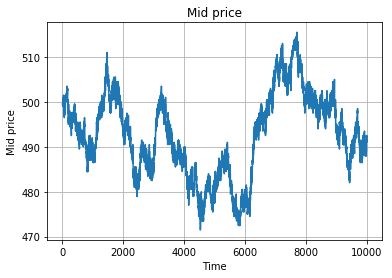

** New parameter values **


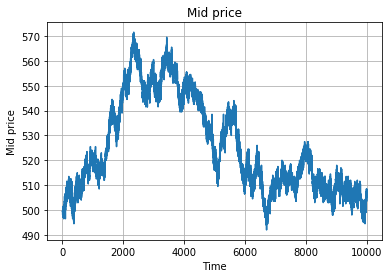

Min mid-price - initial parameter values: 471.5 Min mid-price - new parameter values: 492.0
Max mid-price - initial parameter values: 515.5 Max mid-price - new parameter values: 571.5
Mean mid-price - initial parameter values: 492.6609792869671 Mean mid-price - new parameter values: 525.4975391565076
75% quantile mid-price - initial parameter values: 499.5 Mean mid-price - new parameter values: 543.5
**** Weighted Mid-price part ****
** Inital parameter Values **


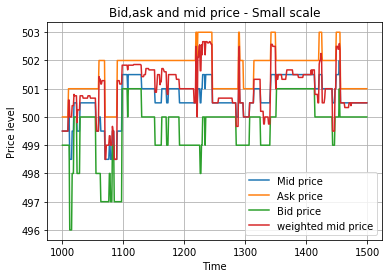

** New parameter values **


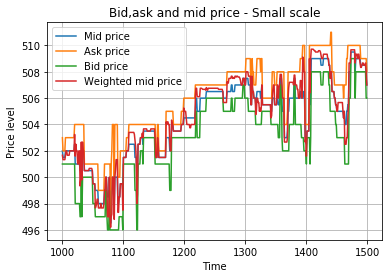

Min weighted mid-price - initial parameter values: 471.125 Min weighted mid-price - new parameter values: 491.4
Max weighted mid-price - initial parameter values: 515.75 Max weighted mid-price - new parameter values: 571.75
Mean weighted mid-price - initial parameter values: 492.6652412625622 Mean weighted mid-price - new parameter values: 525.4738249093386
75% quantile weighted mid-price - initial parameter values: 499.5 Mean weighted mid-price - new parameter values: 543.5
**** Mid-price increments part ****
** Inital parameter Values **


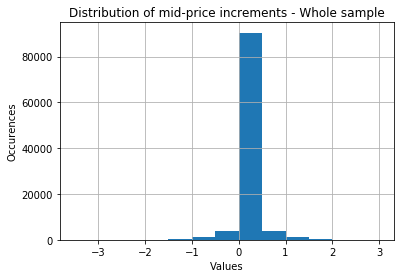

** New parameter values **


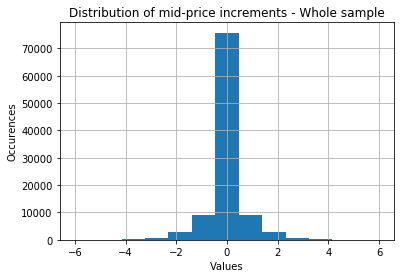

** Initial parameter values **
** New parameter values **


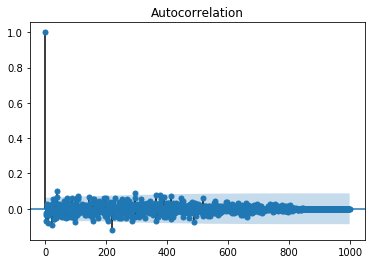

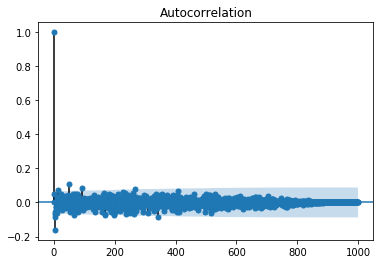

In [28]:
influence_mu(5)

In [29]:
def influence_lamda(lamda):
    
    # Initial parameters values
    Y = np.zeros(1000)
    Y[range(500)] =- 10
    Y[range(500,999)] = 10
    b = orderbooksimulation(1000,10,2.5,1,0.2,Y,10000)
    data = b[0]

    # New parameters values
    Y = np.zeros(1000)
    Y[range(500)] =- 10
    Y[range(500,999)] = 10
    b = orderbooksimulation(1000,10,2.5,lamda,0.2,Y,10000)
    newdata = b[0]
    
    # Spread part:
    ##############
    print('**** Spread part ****')
    #Spread
    print('** Inital parameter Values **')
    plt.plot(data['Time'],data['Spread'])
    plt.title('Spread distribution')
    plt.xlabel('Time')
    plt.ylabel('Spread')
    plt.grid(True)
    plt.show()

    #Spread
    print('** New parameter values **')
    plt.plot(newdata['Time'],newdata['Spread'])
    plt.title('Spread distribution')
    plt.xlabel('Time')
    plt.ylabel('Spread')
    plt.grid(True)
    plt.show()
    
    # Comparison
    print('Min spread - initial parameter values:',min(data['Spread']),'Min spread - new parameter values:', min(newdata['Spread']))
    print('Max spread - initial parameter values:',max(data['Spread']),'Max spread - new parameter values:',max(newdata['Spread']))
    print('Mean spread - initial parameter values:',np.mean(data['Spread']),'Mean spread - new parameter values:',np.mean(newdata['Spread']))
    print('75% quantile spread - initial parameter values:',np.quantile(data['Spread'],0.75),'Mean spread - new parameter values:',np.quantile(newdata['Spread'],0.75))
    
    # Mid price:
    ##############
    print('**** Mid-price part ****')
    # Mid price
    print('** Inital parameter Values **')
    plt.plot(data['Time'],data['Mid price'])
    plt.title('Mid price')
    plt.xlabel('Time')
    plt.ylabel('Mid price')
    plt.grid(True)
    plt.show()

    # Mid price
    print('** New parameter values **')
    plt.plot(newdata['Time'],newdata['Mid price'])
    plt.title('Mid price')
    plt.xlabel('Time')
    plt.ylabel('Mid price')
    plt.grid(True)
    plt.show()
    
    # Comparison
    print('Min mid-price - initial parameter values:',min(data['Mid price']),'Min mid-price - new parameter values:', min(newdata['Mid price']))
    print('Max mid-price - initial parameter values:',max(data['Mid price']),'Max mid-price - new parameter values:',max(newdata['Mid price']))
    print('Mean mid-price - initial parameter values:',np.mean(data['Mid price']),'Mean mid-price - new parameter values:',np.mean(newdata['Mid price']))
    print('75% quantile mid-price - initial parameter values:',np.quantile(data['Mid price'],0.75),'Mean mid-price - new parameter values:', np.quantile(newdata['Mid price'],0.75))
    
    # Weighted mid-price:
    ##############
    print('**** Weighted Mid-price part ****')
    #WMP
    print('** Inital parameter Values **')
    plt.plot(data['Mid price'][1000:1500], label = 'Mid price')
    plt.plot(data['Ask price'][1000:1500], label = 'Ask price')
    plt.plot(data['Bid price'][1000:1500], label = 'Bid price')
    plt.plot(data['Weighted mid price'][1000:1500], label = 'weighted mid price')
    plt.title('Bid,ask and mid price - Small scale')
    plt.xlabel('Time')
    plt.ylabel('Price level')
    plt.legend()
    plt.grid(True)
    plt.show()

    #WMP
    print('** New parameter values **')
    plt.plot(newdata['Mid price'][1000:1500], label = 'Mid price')
    plt.plot(newdata['Ask price'][1000:1500], label = 'Ask price')
    plt.plot(newdata['Bid price'][1000:1500], label = 'Bid price')
    plt.plot(newdata['Weighted mid price'][1000:1500], label = 'Weighted mid price')
    plt.title('Bid,ask and mid price - Small scale')
    plt.xlabel('Time')
    plt.ylabel('Price level')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Comparison
    print('Min weighted mid-price - initial parameter values:',min(data['Weighted mid price']),'Min weighted mid-price - new parameter values:', min(newdata['Weighted mid price']))
    print('Max weighted mid-price - initial parameter values:',max(data['Weighted mid price']),'Max weighted mid-price - new parameter values:',max(newdata['Weighted mid price']))
    print('Mean weighted mid-price - initial parameter values:',np.mean(data['Weighted mid price']),'Mean weighted mid-price - new parameter values:',np.mean(newdata['Weighted mid price']))
    print('75% quantile weighted mid-price - initial parameter values:',np.quantile(data['Weighted mid price'],0.75),'Mean weighted mid-price - new parameter values:', np.quantile(newdata['Weighted mid price'],0.75))
    
    
     # Mid-price increments:
    ##############
    print('**** Mid-price increments part ****')
    
    #Increments
    print('** Inital parameter Values **')
    mid_price = data['Mid price']
    mid_price_diff = data['Mid price'].diff()
    mid_price_diff = mid_price_diff.dropna()
    plt.hist(mid_price_diff, bins = 13)
    plt.title('Distribution of mid-price increments - Whole sample')
    plt.xlabel('Values')
    plt.ylabel('Occurences')
    plt.grid(True)
    plt.show()
    
    #Increments
    print('** New parameter values **')
    mid_price = newdata['Mid price']
    mid_price_diff_new = newdata['Mid price'].diff()
    mid_price_diff_new = mid_price_diff_new.dropna()
    plt.hist(mid_price_diff_new, bins = 13)
    plt.title('Distribution of mid-price increments - Whole sample')
    plt.xlabel('Values')
    plt.ylabel('Occurences')
    plt.grid(True)
    plt.show()
    
    # Autocorrelation part:
    ##############
    
    # Initial parameter values
    print('** Initial parameter values **')
    import statsmodels.graphics.tsaplots as tsa
    tsa.plot_acf(mid_price_diff[:1000])
    
    # New parameter values
    print('** New parameter values **')
    import statsmodels.graphics.tsaplots as tsa
    tsa.plot_acf(mid_price_diff_new[:1000])


**** Spread part ****
** Inital parameter Values **


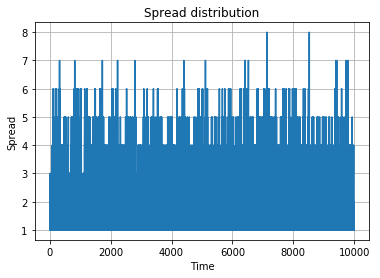

** New parameter values **


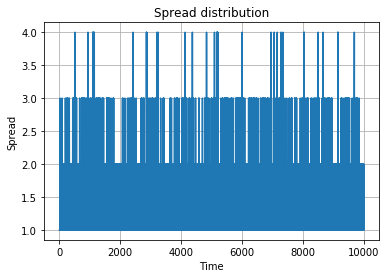

Min spread - initial parameter values: 1 Min spread - new parameter values: 1
Max spread - initial parameter values: 8 Max spread - new parameter values: 4
Mean spread - initial parameter values: 1.9552077605844003 Mean spread - new parameter values: 1.2875581429653158
75% quantile spread - initial parameter values: 3.0 Mean spread - new parameter values: 2.0
**** Mid-price part ****
** Inital parameter Values **


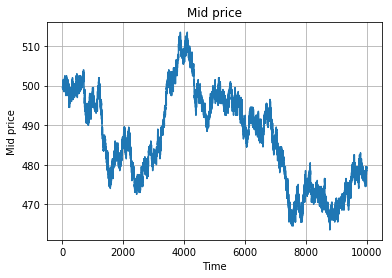

** New parameter values **


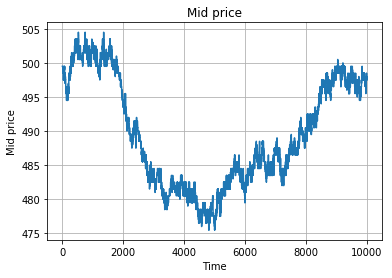

Min mid-price - initial parameter values: 463.5 Min mid-price - new parameter values: 475.5
Max mid-price - initial parameter values: 513.5 Max mid-price - new parameter values: 504.5
Mean mid-price - initial parameter values: 486.7685374283246 Mean mid-price - new parameter values: 489.59323771499373
75% quantile mid-price - initial parameter values: 496.5 Mean mid-price - new parameter values: 497.5
**** Weighted Mid-price part ****
** Inital parameter Values **


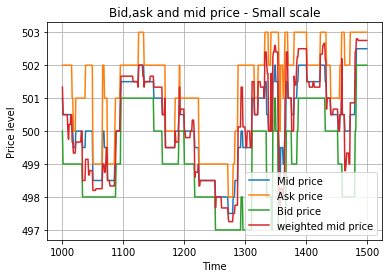

** New parameter values **


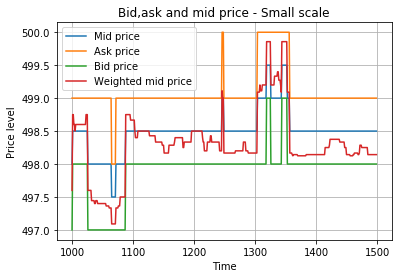

Min weighted mid-price - initial parameter values: 463.3333333333333 Min weighted mid-price - new parameter values: 475.0
Max weighted mid-price - initial parameter values: 513.875 Max weighted mid-price - new parameter values: 504.9375
Mean weighted mid-price - initial parameter values: 486.78035553499893 Mean weighted mid-price - new parameter values: 489.58899329225534
75% quantile weighted mid-price - initial parameter values: 496.5 Mean weighted mid-price - new parameter values: 497.5
**** Mid-price increments part ****
** Inital parameter Values **


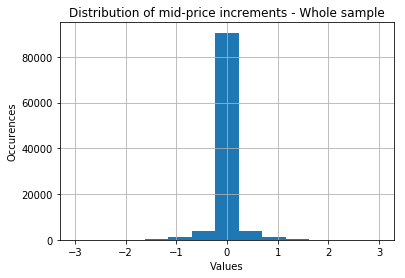

** New parameter values **


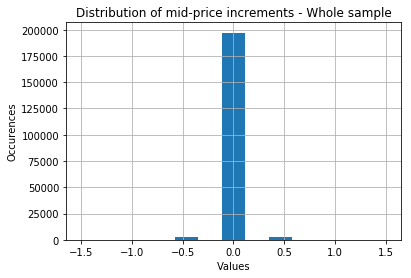

** Initial parameter values **
** New parameter values **


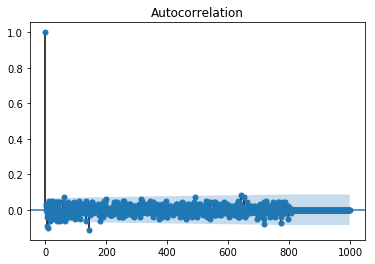

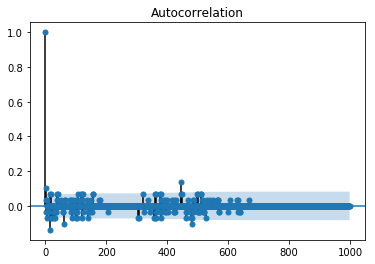

In [30]:
influence_lamda(2)

In [31]:
def influence_theta(theta):
    
    # Initial parameters values
    Y = np.zeros(1000)
    Y[range(500)] =- 10
    Y[range(500,999)] = 10
    b = orderbooksimulation(1000,10,2.5,1,0.2,Y,10000)
    data = b[0]

    # New parameters values
    Y = np.zeros(1000)
    Y[range(500)] =- 10
    Y[range(500,999)] = 10
    b = orderbooksimulation(1000,10,2.5,1,theta,Y,10000)
    newdata = b[0]
    
    # Spread part:
    ##############
    print('**** Spread part ****')
    #Spread
    print('** Inital parameter Values **')
    plt.plot(data['Time'],data['Spread'])
    plt.title('Spread distribution')
    plt.xlabel('Time')
    plt.ylabel('Spread')
    plt.grid(True)
    plt.show()

    #Spread
    print('** New parameter values **')
    plt.plot(newdata['Time'],newdata['Spread'])
    plt.title('Spread distribution')
    plt.xlabel('Time')
    plt.ylabel('Spread')
    plt.grid(True)
    plt.show()
    
    # Comparison
    print('Min spread - initial parameter values:',min(data['Spread']),'Min spread - new parameter values:', min(newdata['Spread']))
    print('Max spread - initial parameter values:',max(data['Spread']),'Max spread - new parameter values:',max(newdata['Spread']))
    print('Mean spread - initial parameter values:',np.mean(data['Spread']),'Mean spread - new parameter values:',np.mean(newdata['Spread']))
    print('75% quantile spread - initial parameter values:',np.quantile(data['Spread'],0.75),'Mean spread - new parameter values:',np.quantile(newdata['Spread'],0.75))
    
    # Mid price:
    ##############
    print('**** Mid-price part ****')
    # Mid price
    print('** Inital parameter Values **')
    plt.plot(data['Time'],data['Mid price'])
    plt.title('Mid price')
    plt.xlabel('Time')
    plt.ylabel('Mid price')
    plt.grid(True)
    plt.show()

    # Mid price
    print('** New parameter values **')
    plt.plot(newdata['Time'],newdata['Mid price'])
    plt.title('Mid price')
    plt.xlabel('Time')
    plt.ylabel('Mid price')
    plt.grid(True)
    plt.show()
    
    # Comparison
    print('Min mid-price - initial parameter values:',min(data['Mid price']),'Min mid-price - new parameter values:', min(newdata['Mid price']))
    print('Max mid-price - initial parameter values:',max(data['Mid price']),'Max mid-price - new parameter values:',max(newdata['Mid price']))
    print('Mean mid-price - initial parameter values:',np.mean(data['Mid price']),'Mean mid-price - new parameter values:',np.mean(newdata['Mid price']))
    print('75% quantile mid-price - initial parameter values:',np.quantile(data['Mid price'],0.75),'Mean mid-price - new parameter values:', np.quantile(newdata['Mid price'],0.75))
    
    # Weighted mid-price:
    ##############
    print('**** Weighted Mid-price part ****')
    #WMP
    print('** Inital parameter Values **')
    plt.plot(data['Mid price'][1000:1500], label = 'Mid price')
    plt.plot(data['Ask price'][1000:1500], label = 'Ask price')
    plt.plot(data['Bid price'][1000:1500], label = 'Bid price')
    plt.plot(data['Weighted mid price'][1000:1500], label = 'weighted mid price')
    plt.title('Bid,ask and mid price - Small scale')
    plt.xlabel('Time')
    plt.ylabel('Price level')
    plt.legend()
    plt.grid(True)
    plt.show()

    #WMP
    print('** New parameter values **')
    plt.plot(newdata['Mid price'][1000:1500], label = 'Mid price')
    plt.plot(newdata['Ask price'][1000:1500], label = 'Ask price')
    plt.plot(newdata['Bid price'][1000:1500], label = 'Bid price')
    plt.plot(newdata['Weighted mid price'][1000:1500], label = 'Weighted mid price')
    plt.title('Bid,ask and mid price - Small scale')
    plt.xlabel('Time')
    plt.ylabel('Price level')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Comparison
    print('Min weighted mid-price - initial parameter values:',min(data['Weighted mid price']),'Min weighted mid-price - new parameter values:', min(newdata['Weighted mid price']))
    print('Max weighted mid-price - initial parameter values:',max(data['Weighted mid price']),'Max weighted mid-price - new parameter values:',max(newdata['Weighted mid price']))
    print('Mean weighted mid-price - initial parameter values:',np.mean(data['Weighted mid price']),'Mean weighted mid-price - new parameter values:',np.mean(newdata['Weighted mid price']))
    print('75% quantile weighted mid-price - initial parameter values:',np.quantile(data['Weighted mid price'],0.75),'Mean weighted mid-price - new parameter values:', np.quantile(newdata['Weighted mid price'],0.75))
    
    
     # Mid-price increments:
    ##############
    print('**** Mid-price increments part ****')
    
    #Increments
    print('** Inital parameter Values **')
    mid_price = data['Mid price']
    mid_price_diff = data['Mid price'].diff()
    mid_price_diff = mid_price_diff.dropna()
    plt.hist(mid_price_diff, bins = 13)
    plt.title('Distribution of mid-price increments - Whole sample')
    plt.xlabel('Values')
    plt.ylabel('Occurences')
    plt.grid(True)
    plt.show()
    
    #Increments
    print('** New parameter values **')
    mid_price = newdata['Mid price']
    mid_price_diff_new = newdata['Mid price'].diff()
    mid_price_diff_new = mid_price_diff_new.dropna()
    plt.hist(mid_price_diff_new, bins = 13)
    plt.title('Distribution of mid-price increments - Whole sample')
    plt.xlabel('Values')
    plt.ylabel('Occurences')
    plt.grid(True)
    plt.show()
    
    # Autocorrelation part:
    ##############
    
    # Initial parameter values
    print('** Initial parameter values **')
    import statsmodels.graphics.tsaplots as tsa
    tsa.plot_acf(mid_price_diff[:1000])
    
    # New parameter values
    print('** New parameter values **')
    import statsmodels.graphics.tsaplots as tsa
    tsa.plot_acf(mid_price_diff_new[:1000])


**** Spread part ****
** Inital parameter Values **


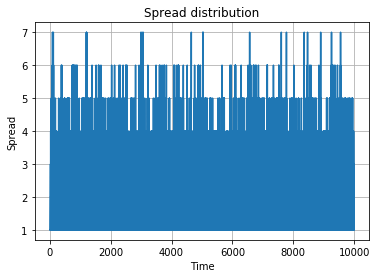

** New parameter values **


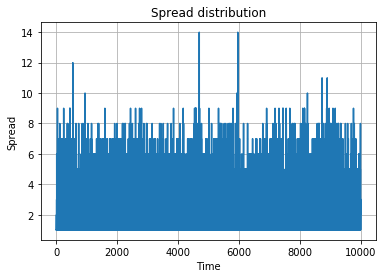

Min spread - initial parameter values: 1 Min spread - new parameter values: 1
Max spread - initial parameter values: 7 Max spread - new parameter values: 14
Mean spread - initial parameter values: 1.9723005571331715 Mean spread - new parameter values: 2.3373550361766053
75% quantile spread - initial parameter values: 3.0 Mean spread - new parameter values: 3.0
**** Mid-price part ****
** Inital parameter Values **


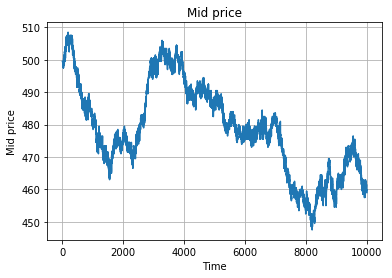

** New parameter values **


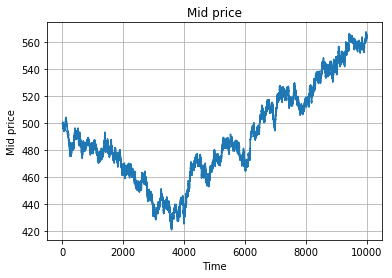

Min mid-price - initial parameter values: 447.5 Min mid-price - new parameter values: 421.0
Max mid-price - initial parameter values: 508.5 Max mid-price - new parameter values: 567.5
Mean mid-price - initial parameter values: 478.5973066983718 Mean mid-price - new parameter values: 490.68234787573596
75% quantile mid-price - initial parameter values: 489.0 Mean mid-price - new parameter values: 517.5
**** Weighted Mid-price part ****
** Inital parameter Values **


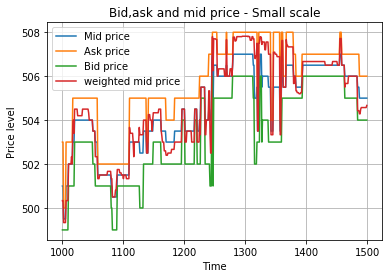

** New parameter values **


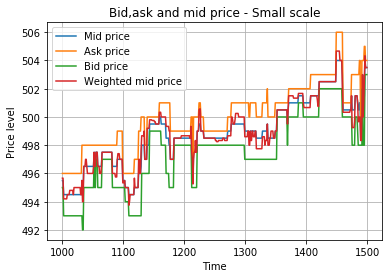

Min weighted mid-price - initial parameter values: 447.1666666666667 Min weighted mid-price - new parameter values: 420.4
Max weighted mid-price - initial parameter values: 508.875 Max weighted mid-price - new parameter values: 567.8
Mean weighted mid-price - initial parameter values: 478.5945291054865 Mean weighted mid-price - new parameter values: 490.6788206624215
75% quantile weighted mid-price - initial parameter values: 488.85714285714283 Mean weighted mid-price - new parameter values: 517.5
**** Mid-price increments part ****
** Inital parameter Values **


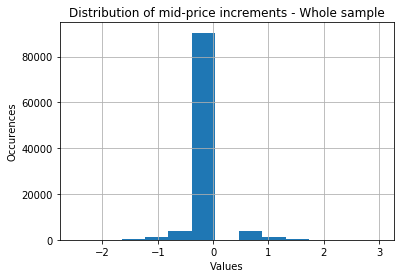

** New parameter values **


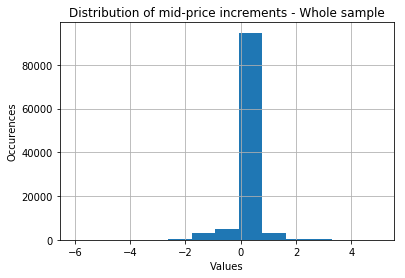

** Initial parameter values **
** New parameter values **


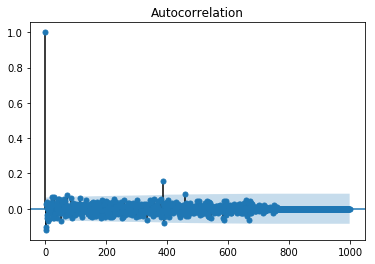

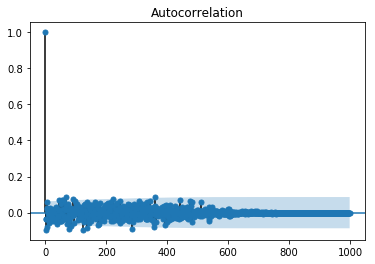

In [32]:
influence_theta(0.5)